In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw5.ipynb")

# CPSC 330 - Applied Machine Learning 

## Homework 5: Putting it all together 
### Associated lectures: All material till lecture 13
### <u>IMPORTANT NOTE:</u> All students must complete HW5 - this homework grade cannot be dropped as part of the lowest homework grade drop policy.

## Table of contents
0. [Submission instructions](#si)
1. [Understanding the problem](#1)
2. [Data splitting](#2)
3. [EDA](#3)
4. [Feature engineering](#4)
5. [Preprocessing and transformations](#5) 
6. [Baseline model](#6)
7. [Linear models](#7)
8. [Different models](#8)
9. [Feature selection](#9)
10. [Hyperparameter optimization](#10)
11. [Interpretation and feature importances](#11) 
12. [Results on the test set](#12)
13. [Summary of the results](#13)
14. [Your takeaway from the course](#15)

<div class="alert alert-info">

## Submission instructions
<hr>
rubric={points:4}

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).
- If you would like to use late tokens for the homework, all group members must have the necessary late tokens available. Please note that the late tokens will be counted for all members of the group.   


Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2024W2/blob/master/docs/homework_instructions.md). 

1. Before submitting the assignment, run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Follow the [CPSC 330 homework instructions](https://ubc-cs.github.io/cpsc330-2024W2/docs/homework_instructions.html), which include information on how to do your assignment and how to submit your assignment.
4. Upload your solution on Gradescope. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope.


_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

</div>

<!-- BEGIN QUESTION -->

## Imports

<div class="alert alert-warning">
    
Imports
    
</div>

_Points:_ 0

In [2]:
import os
import sys
import warnings

warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.base import clone

In [3]:
# From code/plotting_functions.py 
def make_num_tree_plot(preprocessor, X_train, y_train, X_test, y_test, num_trees, scoring_metric='f1'):
    """
    Make number of trees vs error rate plot for RandomForestClassifier

    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set
    X_test: numpy.ndarray
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot

    """
    train_scores = []
    test_scores = []
    for ntree in num_trees:
        model = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=ntree,class_weight="balanced", random_state=123))
        scores = cross_validate(
            model, X_train, y_train, return_train_score=True, scoring=scoring_metric
        )
        train_scores.append(np.mean(scores["train_score"]))
        test_scores.append(np.mean(scores["test_score"]))

    plt.semilogx(num_trees, train_scores, label="train")
    plt.semilogx(num_trees, test_scores, label="cv")
    plt.legend()
    plt.title("RandomForestClassifier Tradeoff")
    plt.xlabel("number of trees")
    plt.ylabel("f1-scores") 

def make_max_depth_plot_xgb(preprocessor, X_train, y_train, X_test, y_test, depths, ratio, scoring_metric='f1'):
    """
    Make number of trees vs error rate plot for RandomForestClassifier

    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray
        The X part of the train set
    y_train: numpy.ndarray
        The y part of the train set
    X_test: numpy.ndarray
    
        The X part of the test/validation set
    y_test: numpy.ndarray
        The y part of the test/validation set
    num_trees: int
        The value for `n_estimators` argument of RandomForestClassifier
    Returns
    -------
        None
        Shows the number of trees vs error rate plot

    """
    train_scores = []
    test_scores = []
    for d in depths:
        model = make_pipeline(preprocessor, XGBClassifier(max_depth=d, scale_pos_weight=ratio,random_state=123, verbosity=0))
        scores = cross_validate(
            model, X_train, y_train, return_train_score=True, scoring=scoring_metric
        )
        train_scores.append(np.mean(scores["train_score"]))
        test_scores.append(np.mean(scores["test_score"]))

    plt.semilogx(depths, train_scores, label="train")
    plt.semilogx(depths, test_scores, label="cv")
    plt.legend()
    plt.title("XGBClassifier Tradeoff")
    plt.xticks(depths)
    plt.xlabel("max_depth")
    plt.ylabel("f1-scores") 

def randomized_tuning(pipe, param_grid, n_iter):
    random_search = RandomizedSearchCV(pipe,                                    
                  param_distributions = param_grid, 
                  n_iter=n_iter, 
                  n_jobs=-1, 
                  return_train_score=True,
                  scoring="f1",
                  random_state=123)

    random_search.fit(X_train, y_train)

    result_cols = [
        "mean_test_score",
        "mean_fit_time",
        "rank_test_score"
    ]
    for param in param_grid.keys():
        result_cols.append(f"param_{param}")
    
    display(pd.DataFrame(random_search.cv_results_)[result_cols].set_index("rank_test_score").sort_index().T)

    return random_search

<!-- END QUESTION -->

## Introduction <a name="in"></a>

In this homework you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (15-20 hours???) is a good guideline for this project . Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

<!-- BEGIN QUESTION -->

## 1. Pick your problem and explain the prediction problem <a name="1"></a>
<hr>
rubric={points:3}

In this mini project, you have the option to choose on which dataset you will be working on. The tasks you will need to carry on will be similar, independently of your choice.

### Option 1
You can choose to work on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 


### Option 2
You can choose to work on a regression problem using a [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019. As usual, you'll need to start by downloading the dataset, then you will try to predict `reviews_per_month`, as a proxy for the popularity of the listing. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

> Note there is an updated version of this dataset with more features available [here](http://insideairbnb.com/). The features were are using in `listings.csv.gz` for the New York city datasets. You will also see some other files like `reviews.csv.gz`. For your own interest you may want to explore the expanded dataset and try your analysis there. However, please submit your results on the dataset obtained from Kaggle.


**Your tasks:**

1. Spend some time understanding the options and pick the one you find more interesting (it may help spending some time looking at the documentation available on Kaggle for each dataset).
2. After making your choice, focus on understanding the problem and what each feature means, again using the documentation on the dataset page on Kaggle. Write a few sentences on your initial thoughts on the problem and the dataset. 
3. Download the dataset and read it as a pandas dataframe. 

<div class="alert alert-warning">
    
Solution_1
    
</div>

_Points:_ 3

I picked the first problem: Default Credit Card Clients Dataset. I prefer to work with this one because I think it is more intuitive to interpret the columns which are mostly numerical, as opposed to the second dataset which has more categorical features. The problem itself is also more intuitive for me, so it's easier to decide which columns I want to use or drop. The columns are the repayment status, amount of bill statement, and previous statement of the past 6 months, in addition to id, limit, sex, education, marriage status, and age. I am going to drop sex since I believe gender doesn't effect whether or not someone will pay their credit card.

In [4]:
creditcard_df = pd.read_csv("data/UCI_Credit_Card.csv", index_col=0)
creditcard_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train (70%) and test (30%) portions with `random_state=123`.

> If your computer cannot handle training on 70% training data, make the test split bigger.  

<div class="alert alert-warning">
    
Solution_2
    
</div>

_Points:_ 2

In [5]:
train_df, test_df = train_test_split(
    creditcard_df, test_size=0.3, random_state=123, stratify=creditcard_df["default.payment.next.month"]
)

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

<div class="alert alert-warning">
    
Solution_3
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21000 entries, 14452 to 13417
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   21000 non-null  float64
 1   SEX                         21000 non-null  int64  
 2   EDUCATION                   21000 non-null  int64  
 3   MARRIAGE                    21000 non-null  int64  
 4   AGE                         21000 non-null  int64  
 5   PAY_0                       21000 non-null  int64  
 6   PAY_2                       21000 non-null  int64  
 7   PAY_3                       21000 non-null  int64  
 8   PAY_4                       21000 non-null  int64  
 9   PAY_5                       21000 non-null  int64  
 10  PAY_6                       21000 non-null  int64  
 11  BILL_AMT1                   21000 non-null  float64
 12  BILL_AMT2                   21000 non-null  float64
 13  BILL_AMT3                   2100

We can see that for all features/columns, we have 2100 non-nulls, which is the same as the number of samples we have in our training data. Since it seems like no value is missing, (spoiler: this is false after we do some more EDA below). Here are some of my observation based on the datatype:
- I am dropping sex for gender equality and avoid historical bias (if any)
- MARRIAGE has int64 datatype, but we have to see it as categorical
- EDUCATION has int64 datatype. Initially I'd like to use ordinal encoding for this feature so it made sense, but seeing how we have 4='others', it isn't fair to assume it has a lower rank than high school. The client may have completed a higher education that is just not a standard education in Taiwan, therefore it falls to 'others'. Because of this, I decided to make it as categorical feature
- int64 makes sense for PAY, since we may have to do ordinal encoding
- AGE, BILL_AMT, and PAY_AMT are numerical features that has to be scaled (very different range as seen below)

In [7]:
train_df.describe(include='all')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,167627.318095,1.602476,1.855762,1.551048,35.488476,-0.017429,-0.127810,-0.159238,-0.216095,-0.259524,...,43295.839476,40389.043095,38838.993143,5663.359190,5.990677e+03,5214.520762,4876.729810,4747.745952,5135.359143,0.221190
std,129860.863421,0.489398,0.787604,0.523430,9.224177,1.125270,1.199651,1.203743,1.174019,1.138940,...,64297.470511,60866.714551,59587.880749,16612.876887,2.508848e+04,18035.872826,16423.808259,14813.761614,17679.532366,0.415058
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-28335.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2318.750000,1776.000000,1315.750000,1000.000000,8.557500e+02,390.000000,300.000000,278.750000,109.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19119.500000,18160.500000,17094.500000,2100.000000,2.010500e+03,1800.000000,1500.000000,1509.500000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54928.750000,50229.750000,49286.250000,5001.000000,5.000000e+03,4529.250000,4000.000000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,7.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


Here are some of my observations that doesn't quite make sense:
- min of 0 for MARRIAGE is not consistent with kraggle's provided scale (1=married, 2=single, 3=others)
- min of 0 for EDUCATION is also not consistent with kraggle's provided scale (starts with 1)
- min of -2 for PAY is also not consistent with kraggle's provided scale (starts with -1=pay duly). Upon further research on Kraggle's discussion (https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608), here is what the complete scale looks like:

  **-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; . . .**

I am going to assume the 0 values for MARRIAGE and EDUCATION means unknown, not others because they're not the same.

In [8]:
train_df['MARRIAGE'].value_counts()

MARRIAGE
2    11125
1     9596
3      242
0       37
Name: count, dtype: int64

In [9]:
# Even though numbers technically work even for categorical, for easier
# interpretation and further EDA, I am converting these numbers to strings
marriage_map = {
    1: 'married',
    2: 'single',
    3: 'others',
    0: np.nan
}

train_df['MARRIAGE'] = train_df['MARRIAGE'].map(marriage_map)
test_df['MARRIAGE'] = test_df['MARRIAGE'].map(marriage_map)

train_df['MARRIAGE'].value_counts()

MARRIAGE
single     11125
married     9596
others       242
Name: count, dtype: int64

In [10]:
train_df['EDUCATION'].value_counts()

EDUCATION
2    9875
1    7346
3    3451
5     194
4      90
6      32
0      12
Name: count, dtype: int64

Based on Kraggle: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)

So, 0,5,6 are unknowns.

In [11]:
education_map = {
    1: 'graduate school',
    2: 'university',
    3: 'high school',
    4: 'others',
    5: np.nan,
    6: np.nan,
    0: np.nan
}

train_df['EDUCATION'] = train_df['EDUCATION'].map(education_map)
test_df['EDUCATION'] = test_df['EDUCATION'].map(education_map)
train_df['EDUCATION'].value_counts()

EDUCATION
university         9875
graduate school    7346
high school        3451
others               90
Name: count, dtype: int64

Now that we have missing values, we'll have to do imputation later.

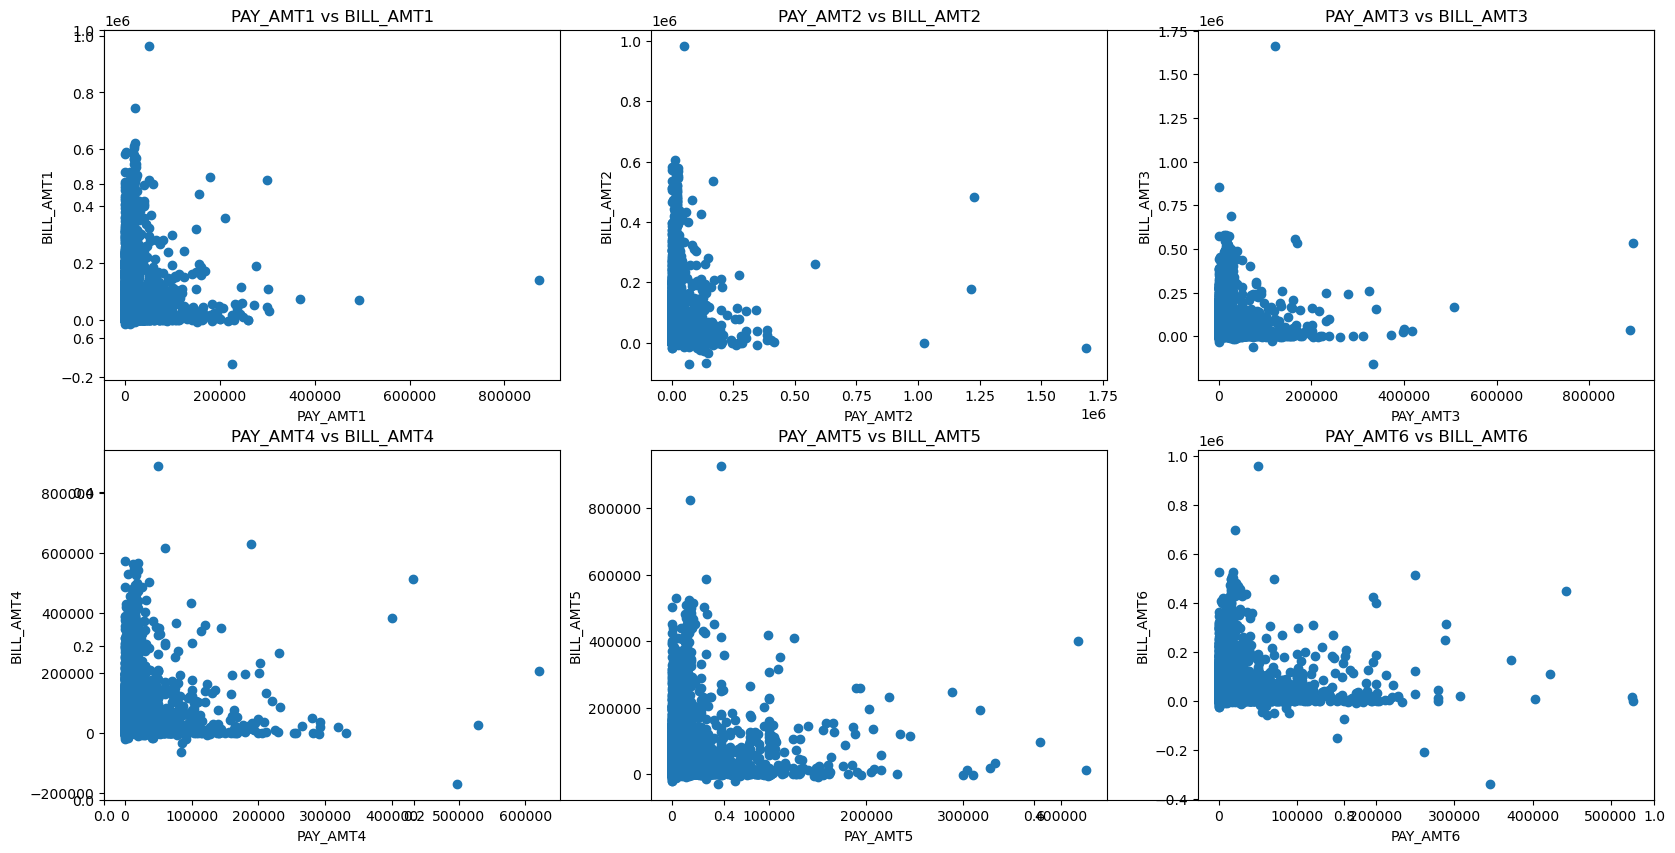

In [12]:
x = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
y = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
plt.subplots(figsize=(20,10))
subplot_num = 231

for i in range(6):
    feat_x = x[i]
    feat_y = y[i]
    plt.subplot(subplot_num)
    plt.scatter(x = train_df[feat_x], y = train_df[feat_y])
    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.title(f"{feat_x} vs {feat_y}")
    subplot_num+=1

plt.show()



In [13]:
# for col in numeric_cols:
#     train_df.groupby("income")[col].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + col);
#     plt.xlabel(col);
#     plt.show()

In [14]:
...

Ellipsis

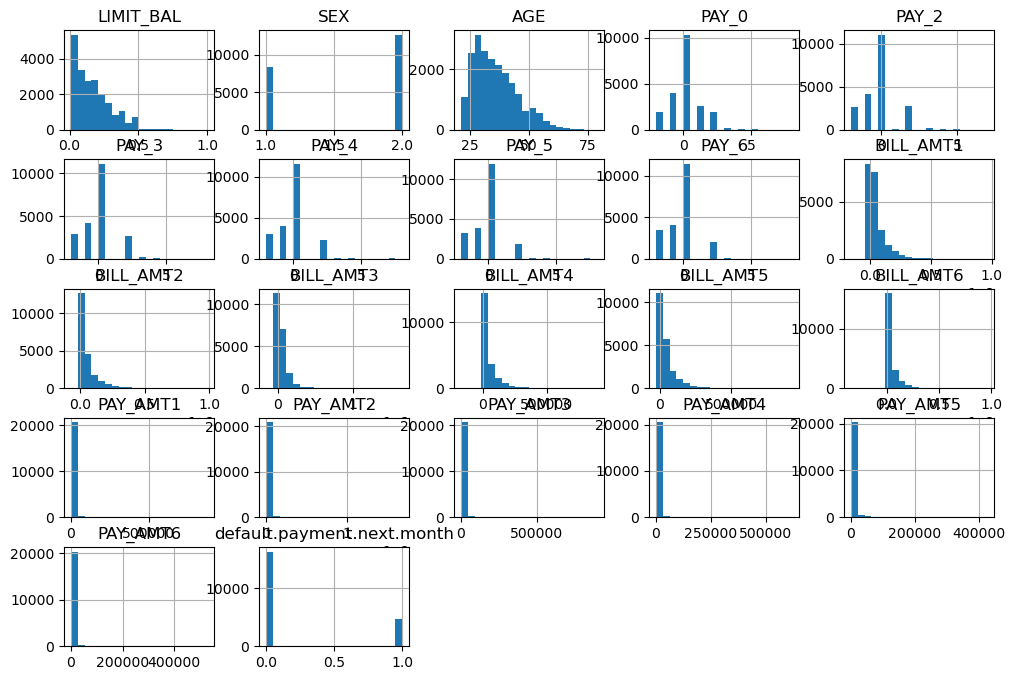

In [15]:
train_df.hist(bins=20, figsize=(12, 8));

In [16]:
train_df["default.payment.next.month"].value_counts()

default.payment.next.month
0    16355
1     4645
Name: count, dtype: int64

We have a class imbalance with the negative class dominating. So accuracy might not be the best metric to use. Since this is a classification problem, I am going to use precision, recall, and F1 score. I am mainly going to look at F1 since it is the harmonic mean of recall and precision, and it is not clear whether we are minimizing false positive or false negative (prioritize precision or recall).

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<div class="alert alert-warning">
    
Solution_4
    
</div>

_Points:_ 1

In [17]:
for i in range(6):
    col1_name = f"UNPAID_AMT{i+1}"
    train_df[col1_name] = train_df[f"BILL_AMT{i+1}"] - train_df[f"PAY_AMT{i+1}"]
    test_df[col1_name] = test_df[f"BILL_AMT{i+1}"] - test_df[f"PAY_AMT{i+1}"]

    col2_name = f"UTILIZATION{i+1}"
    train_df[col2_name] = train_df[f"BILL_AMT{i+1}"] / train_df["LIMIT_BAL"]
    test_df[col2_name] = test_df[f"BILL_AMT{i+1}"] - test_df["LIMIT_BAL"]
train_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,UNPAID_AMT2,UTILIZATION2,UNPAID_AMT3,UTILIZATION3,UNPAID_AMT4,UTILIZATION4,UNPAID_AMT5,UTILIZATION5,UNPAID_AMT6,UTILIZATION6
ID,,,,,,,,,,,,,,,,,,,,,
14452,20000.0,1,high school,married,52,-1,-1,-1,-1,-1,...,-390.0,0.019500,0.0,0.039000,0.0,0.039000,390.0,0.039000,-390.0,0.019500
18393,230000.0,2,university,single,24,-1,-1,-1,-1,-1,...,-349.0,0.001030,-12075.0,0.001896,11239.0,0.054296,932.0,0.004052,317.0,0.001378
24956,360000.0,1,high school,single,31,1,-1,2,-1,0,...,238.0,0.000661,-3492.0,0.000661,3530.0,0.010361,3930.0,0.010917,3930.0,0.010917
7163,90000.0,2,university,married,26,2,0,0,0,0,...,87629.0,1.021433,84933.0,0.982589,84510.0,0.977889,84114.0,0.975711,84731.0,0.975900
12126,20000.0,2,graduate school,single,29,1,2,0,0,0,...,4980.0,0.304900,6695.0,0.355350,6707.0,0.370050,7826.0,0.391300,7252.0,0.377600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27166,280000.0,1,university,married,40,1,2,0,0,0,...,220523.0,0.816154,185098.0,0.682493,155149.0,0.571961,144421.0,0.551504,151022.0,0.557221
3229,50000.0,2,university,married,26,0,0,0,0,0,...,39560.0,0.841200,40672.0,0.846640,36415.0,0.757440,34448.0,0.714960,32291.0,0.672620
23478,100000.0,2,university,single,30,1,2,0,0,2,...,29054.0,0.309040,28753.0,0.319530,32808.0,0.343080,34951.0,0.349510,32761.0,0.342610


In [18]:
X_train = train_df.drop(columns=["default.payment.next.month"])
y_train = train_df["default.payment.next.month"]
X_test = test_df.drop(columns=["default.payment.next.month"])
y_test = test_df["default.payment.next.month"]
X_train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,UNPAID_AMT2,UTILIZATION2,UNPAID_AMT3,UTILIZATION3,UNPAID_AMT4,UTILIZATION4,UNPAID_AMT5,UTILIZATION5,UNPAID_AMT6,UTILIZATION6
ID,,,,,,,,,,,,,,,,,,,,,
14452,20000.0,1,high school,married,52,-1,-1,-1,-1,-1,...,-390.0,0.019500,0.0,0.039000,0.0,0.039000,390.0,0.039000,-390.0,0.019500
18393,230000.0,2,university,single,24,-1,-1,-1,-1,-1,...,-349.0,0.001030,-12075.0,0.001896,11239.0,0.054296,932.0,0.004052,317.0,0.001378
24956,360000.0,1,high school,single,31,1,-1,2,-1,0,...,238.0,0.000661,-3492.0,0.000661,3530.0,0.010361,3930.0,0.010917,3930.0,0.010917
7163,90000.0,2,university,married,26,2,0,0,0,0,...,87629.0,1.021433,84933.0,0.982589,84510.0,0.977889,84114.0,0.975711,84731.0,0.975900
12126,20000.0,2,graduate school,single,29,1,2,0,0,0,...,4980.0,0.304900,6695.0,0.355350,6707.0,0.370050,7826.0,0.391300,7252.0,0.377600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27166,280000.0,1,university,married,40,1,2,0,0,0,...,220523.0,0.816154,185098.0,0.682493,155149.0,0.571961,144421.0,0.551504,151022.0,0.557221
3229,50000.0,2,university,married,26,0,0,0,0,0,...,39560.0,0.841200,40672.0,0.846640,36415.0,0.757440,34448.0,0.714960,32291.0,0.672620
23478,100000.0,2,university,single,30,1,2,0,0,2,...,29054.0,0.309040,28753.0,0.319530,32808.0,0.343080,34951.0,0.349510,32761.0,0.342610


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

<div class="alert alert-warning">
    
Solution_5
    
</div>

_Points:_ 10

In [19]:
numerical_feats = ["LIMIT_BAL", "AGE", 
                 "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
                "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
                  "UNPAID_AMT1", "UNPAID_AMT2", "UNPAID_AMT3", "UNPAID_AMT4", "UNPAID_AMT5", "UNPAID_AMT6",
                "UTILIZATION1", "UTILIZATION2", "UTILIZATION3", "UTILIZATION4", "UTILIZATION5", "UTILIZATION6"]
ordinal_feats = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
categorical_feats = ["EDUCATION","MARRIAGE"]  
drop_feats = ["ID","SEX"]

In [20]:
categories = [list(range(-2, 10))] * 6
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='missing'),
    OneHotEncoder(handle_unknown='ignore'))

ct = make_column_transformer((StandardScaler(), numerical_feats),
                              (categorical_transformer, categorical_feats),
                                (OrdinalEncoder(categories= categories, handle_unknown='use_encoded_value', unknown_value=-3), ordinal_feats))
ct.fit_transform(X_train)
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2',
                                  'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
                                  'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
                                  'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
                                  'PAY_AMT6', 'UNPAID_AMT1', 'UNPAID_AMT2',
                                  'UNPAID_AMT3', 'UNPAID_AMT4', 'UNPAID_AMT5',
                                  'UNPAID_AMT6', 'UTILIZATION1', 'UTILIZATION2',
                                  'UTILIZATION...
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['EDUCATION', 'MARRIAGE']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[[-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8, 9],
                                                            [-2, -1, 0, 1, 2, 3,
                                                             4, 5, 6, 7, 8,
                                                             9]],
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-3),
                                 ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
                                  'PAY_6'])])

In [21]:
column_names = (
    numerical_feats
    + ct.named_transformers_['pipeline'].named_steps['onehotencoder'].get_feature_names_out().tolist()
    + ordinal_feats
)
transformed = pd.DataFrame(ct.fit_transform(X_train), columns=column_names)

display(column_names)
display(transformed)


['LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'UNPAID_AMT1',
 'UNPAID_AMT2',
 'UNPAID_AMT3',
 'UNPAID_AMT4',
 'UNPAID_AMT5',
 'UNPAID_AMT6',
 'UTILIZATION1',
 'UTILIZATION2',
 'UTILIZATION3',
 'UTILIZATION4',
 'UTILIZATION5',
 'UTILIZATION6',
 'x0_graduate school',
 'x0_high school',
 'x0_missing',
 'x0_others',
 'x0_university',
 'x1_married',
 'x1_missing',
 'x1_others',
 'x1_single',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,x1_married,x1_missing,x1_others,x1_single,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,-1.136839,1.790069,-0.657579,-0.688869,-0.666980,-0.661252,-0.650766,-0.645264,-0.317434,-0.207697,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.480315,-1.245504,-0.695228,-0.691038,-0.671947,-0.479157,-0.648269,-0.646489,-0.326644,-0.215430,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0
2,1.481411,-0.486611,-0.697417,-0.691024,-0.674806,-0.615371,-0.599012,-0.585854,-0.326583,-0.238788,...,0.0,0.0,0.0,1.0,3.0,1.0,4.0,1.0,2.0,2.0
3,-0.597787,-1.028677,0.533114,0.609232,0.598528,0.695443,0.779179,0.822200,-0.039931,-0.067390,...,1.0,0.0,0.0,0.0,4.0,2.0,2.0,2.0,2.0,2.0
4,-1.136839,-0.703437,-0.610613,-0.607924,-0.575633,-0.558275,-0.535002,-0.525069,-0.340910,-0.194224,...,0.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,0.865352,0.489109,2.559857,2.546250,2.080775,1.817427,1.873514,1.966605,-0.340910,0.080091,...,1.0,0.0,0.0,0.0,3.0,4.0,2.0,2.0,2.0,2.0
20996,-0.905817,-1.028677,-0.099286,-0.097953,-0.067065,-0.084357,-0.076251,-0.087402,-0.206794,-0.139138,...,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
20997,-0.520780,-0.595024,-0.263631,-0.256154,-0.216914,-0.139789,-0.089346,-0.076829,-0.340910,-0.165047,...,0.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,4.0,4.0
20998,1.096374,-0.920264,-0.680165,-0.676517,-0.660036,-0.647706,-0.657174,-0.645264,-0.265003,-0.188524,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0


<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 6. Baseline model <a name="6"></a>
<hr>
rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

<div class="alert alert-warning">
    
Solution_6
    
</div>

_Points:_ 2

In [22]:
# Adapted from HW 3
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [23]:
score_metrics = ["f1", "precision", "recall"]
results_dict = {}
pipe_dummy = make_pipeline(ct, DummyClassifier(random_state = 123))
results_dict["dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.048 (+/- 0.002),0.017 (+/- 0.001),0.779 (+/- 0.000),0.779 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)


In [24]:
train_df["default.payment.next.month"].value_counts()

default.payment.next.month
0    16355
1     4645
Name: count, dtype: int64

Since the dominating target class in the training set is 0 (negative), DummyClassifier always predict 0. Therefore, $TP = FP = 0$. So Precision is set to 0 because it is undefined ($Precision= \frac{TP}{TP+FP} = \frac{0}{0}$). We can also see that Recall is also 0 because $Recall = \frac{TP}{TP+FN} = \frac{0}{FN} = 0$. Since both precision and recall is 0, f1 is also 0

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

<div class="alert alert-warning">
    
Solution_7
    
</div>

_Points:_ 10

In [25]:
pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=1000, class_weight="balanced", random_state=123))
results_dict["Logistic Regression (no tuning)"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.048 (+/- 0.002),0.017 (+/- 0.001),0.779 (+/- 0.000),0.779 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression (no tuning),0.185 (+/- 0.019),0.017 (+/- 0.000),0.696 (+/- 0.006),0.698 (+/- 0.006),0.385 (+/- 0.006),0.387 (+/- 0.006),0.623 (+/- 0.027),0.629 (+/- 0.004),0.476 (+/- 0.010),0.479 (+/- 0.005)


In [26]:
lr_tuning_results_dict={}
scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
}

for C in scores_dict["C"]:
    pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=1000, class_weight="balanced", C=C, random_state=123))
    lr_tuning_results_dict[C] = mean_std_cross_val_scores(pipe_lr, X_train, y_train, return_train_score=True, scoring = score_metrics)

lr_tuning_results_df = pd.DataFrame(lr_tuning_results_dict).T
lr_tuning_results_df

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0.0001,0.070 (+/- 0.007),0.017 (+/- 0.001),0.672 (+/- 0.011),0.671 (+/- 0.007),0.360 (+/- 0.014),0.360 (+/- 0.007),0.623 (+/- 0.029),0.624 (+/- 0.005),0.456 (+/- 0.018),0.457 (+/- 0.007)
0.0010,0.101 (+/- 0.029),0.018 (+/- 0.001),0.701 (+/- 0.008),0.704 (+/- 0.009),0.388 (+/- 0.009),0.392 (+/- 0.010),0.605 (+/- 0.030),0.613 (+/- 0.005),0.472 (+/- 0.012),0.478 (+/- 0.006)
0.0100,0.116 (+/- 0.015),0.018 (+/- 0.001),0.701 (+/- 0.007),0.702 (+/- 0.006),0.389 (+/- 0.008),0.392 (+/- 0.006),0.619 (+/- 0.027),0.625 (+/- 0.003),0.478 (+/- 0.011),0.482 (+/- 0.005)
0.1000,0.193 (+/- 0.019),0.018 (+/- 0.001),0.698 (+/- 0.006),0.699 (+/- 0.006),0.386 (+/- 0.007),0.388 (+/- 0.006),0.622 (+/- 0.026),0.628 (+/- 0.003),0.476 (+/- 0.011),0.480 (+/- 0.005)
1.0000,0.191 (+/- 0.021),0.018 (+/- 0.001),0.696 (+/- 0.006),0.698 (+/- 0.006),0.385 (+/- 0.006),0.387 (+/- 0.006),0.623 (+/- 0.027),0.629 (+/- 0.004),0.476 (+/- 0.010),0.479 (+/- 0.005)
10.0000,0.241 (+/- 0.015),0.018 (+/- 0.001),0.696 (+/- 0.006),0.697 (+/- 0.006),0.384 (+/- 0.007),0.387 (+/- 0.007),0.622 (+/- 0.027),0.629 (+/- 0.003),0.475 (+/- 0.011),0.479 (+/- 0.005)
100.0000,0.203 (+/- 0.029),0.018 (+/- 0.001),0.696 (+/- 0.005),0.698 (+/- 0.006),0.384 (+/- 0.006),0.387 (+/- 0.006),0.623 (+/- 0.027),0.629 (+/- 0.003),0.475 (+/- 0.010),0.479 (+/- 0.005)
1000.0000,0.204 (+/- 0.027),0.017 (+/- 0.001),0.696 (+/- 0.005),0.698 (+/- 0.006),0.384 (+/- 0.006),0.387 (+/- 0.006),0.623 (+/- 0.027),0.629 (+/- 0.004),0.475 (+/- 0.010),0.479 (+/- 0.005)
10000.0000,0.257 (+/- 0.026),0.018 (+/- 0.002),0.696 (+/- 0.006),0.697 (+/- 0.006),0.384 (+/- 0.006),0.387 (+/- 0.007),0.622 (+/- 0.027),0.629 (+/- 0.003),0.475 (+/- 0.010),0.479 (+/- 0.005)
100000.0000,0.314 (+/- 0.157),0.018 (+/- 0.001),0.696 (+/- 0.006),0.698 (+/- 0.006),0.384 (+/- 0.006),0.387 (+/- 0.006),0.622 (+/- 0.027),0.629 (+/- 0.004),0.475 (+/- 0.010),0.479 (+/- 0.005)


As seen, different scoring metric gives different scores, and the best C changes depending on which metric we see, but we are prioritizing f1 score. C=0.01 has a best f1 score of 0.478. I'll try to narrow down the range around that value.

In [29]:
best_C = 0.01 

In [30]:
pipe_lr = make_pipeline(ct, LogisticRegression(max_iter=1000, C=best_C, class_weight="balanced", random_state=123))
results_dict["Logistic Regression (best C)"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)
results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.048 (+/- 0.002),0.017 (+/- 0.001),0.779 (+/- 0.000),0.779 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression (no tuning),0.185 (+/- 0.019),0.017 (+/- 0.000),0.696 (+/- 0.006),0.698 (+/- 0.006),0.385 (+/- 0.006),0.387 (+/- 0.006),0.623 (+/- 0.027),0.629 (+/- 0.004),0.476 (+/- 0.010),0.479 (+/- 0.005)
Logistic Regression (best C),0.116 (+/- 0.013),0.017 (+/- 0.000),0.701 (+/- 0.007),0.702 (+/- 0.006),0.389 (+/- 0.008),0.392 (+/- 0.006),0.619 (+/- 0.027),0.625 (+/- 0.003),0.478 (+/- 0.011),0.482 (+/- 0.005)


The best result I got is with C = 0.01 with a test f1 score of 0.478, though this is just a slight increase. The standard deviation is low which shows that there is not much variation across the folds. Since it is also close with train f1-score, there doesn't seem to be an optimization bias. 

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 8. Different models <a name="8"></a>
<hr>
rubric={points:12}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. One of these models should be a tree-based ensemble model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

<div class="alert alert-warning">
    
Solution_8
    
</div>

_Points:_ 12

In [31]:
ratio = np.bincount(y_train)[0] / np.bincount(y_train)[1] # recommended ratio from documentation

In [32]:
# Adapted from lecture 11

# pipe_knn = make_pipeline(ct, KNeighborsClassifier())
# pipe_svc = make_pipeline(ct, SVC(class_weight="balanced", random_state=123))
pipe_rf = make_pipeline(ct, RandomForestClassifier(class_weight="balanced", random_state=123))
pipe_xgb = make_pipeline(ct, XGBClassifier(scale_pos_weight= ratio ,random_state=123, verbosity=0))
pipe_lgbm = make_pipeline(ct, LGBMClassifier(scale_pos_weight=ratio,random_state=123, verbose=-1))
# pipe_catboost = make_pipeline(ct, CatBoostClassifier(auto_class_weights='Balanced',verbose=0, random_state=123))

classifiers = {
    # "k-NN": pipe_knn,
    # "SVM RBF": pipe_svc,
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    # "CatBoost": pipe_catboost,
}

for (name, model) in classifiers.items():
    results_dict[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=score_metrics
    )

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
dummy,0.048 (+/- 0.002),0.017 (+/- 0.001),0.779 (+/- 0.000),0.779 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
Logistic Regression (no tuning),0.185 (+/- 0.019),0.017 (+/- 0.000),0.696 (+/- 0.006),0.698 (+/- 0.006),0.385 (+/- 0.006),0.387 (+/- 0.006),0.623 (+/- 0.027),0.629 (+/- 0.004),0.476 (+/- 0.010),0.479 (+/- 0.005)
Logistic Regression (best C),0.116 (+/- 0.013),0.017 (+/- 0.000),0.701 (+/- 0.007),0.702 (+/- 0.006),0.389 (+/- 0.008),0.392 (+/- 0.006),0.619 (+/- 0.027),0.625 (+/- 0.003),0.478 (+/- 0.011),0.482 (+/- 0.005)
random forest,5.877 (+/- 0.094),0.099 (+/- 0.005),0.811 (+/- 0.005),0.999 (+/- 0.000),0.644 (+/- 0.022),0.997 (+/- 0.001),0.324 (+/- 0.011),1.000 (+/- 0.000),0.431 (+/- 0.014),0.998 (+/- 0.000)
XGBoost,0.304 (+/- 0.070),0.027 (+/- 0.001),0.765 (+/- 0.005),0.918 (+/- 0.006),0.473 (+/- 0.009),0.752 (+/- 0.014),0.555 (+/- 0.023),0.939 (+/- 0.008),0.510 (+/- 0.011),0.835 (+/- 0.011)
LightGBM,0.598 (+/- 0.911),0.023 (+/- 0.002),0.761 (+/- 0.002),0.831 (+/- 0.001),0.469 (+/- 0.004),0.585 (+/- 0.002),0.627 (+/- 0.023),0.812 (+/- 0.009),0.537 (+/- 0.010),0.680 (+/- 0.002)


SVM RBF and all three of the gradient boosted trees have better f1 scores (and accuracy) than the linear model. However, in terms of fit and score time, almost every one of them are worse, especially SVM RBF (worst!), CatBoost, and random forest. The others took slightly longer time (but still fairly reasonable), except for k-NN which has a shorter fit time. This makes sense because the k-NN does all the work during scoring, not training.

None of them seem to be overfitting, except for maybe random forest and XGBoost. Random forest has both accuracy and f1 score of almost 1 on train set but fairly low on test set. However, this does not necessarily mean it is overfitting. As seen below, the validation score doesn't decrease when we increase the training score even beyond 100 (default).

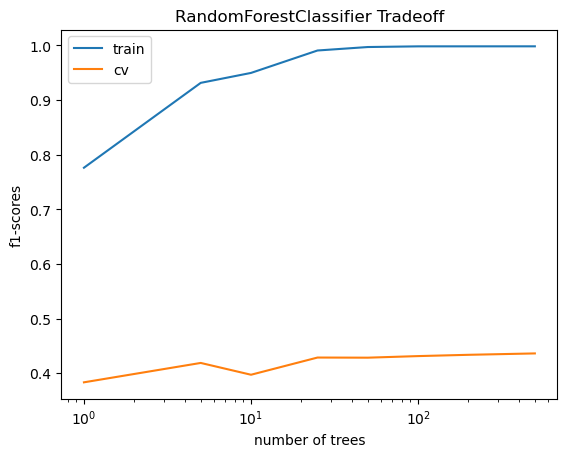

In [38]:
make_num_tree_plot( # defined on cell 3, from lectures/code/plotting_functions.py but tweaked a little
    ct, X_train, y_train, X_test, y_test, [1, 5, 10, 25, 50, 100, 200, 500]
)

For XGBoost:

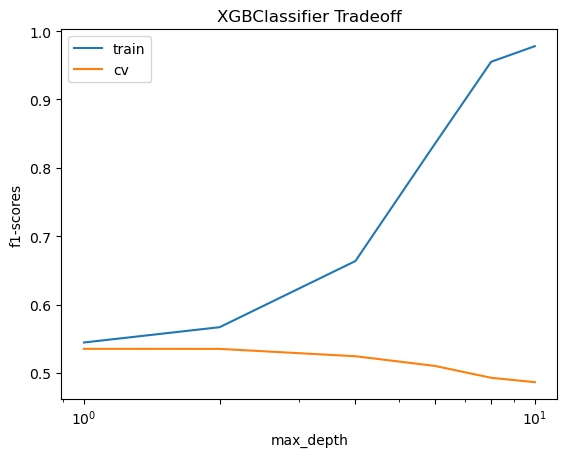

In [39]:
make_max_depth_plot_xgb( # defined on cell 3
    ct, X_train, y_train, X_test, y_test, [1, 2, 4, 6, 8, 10], ratio
)

It does seem like we are overfitting with XGBoost (default depth=6). One thing I noticed is that the score was already decreasing from max_depth=1. This could be due to other hyperparameter. We could try tuning max_depth further with other hyperparameters, or we could use another model that has a higher score initially, like LightGBM or CatBoost.

From here onward, I am going to work mainly with the LogisticRegression, RandomForest, and the best of the Gradient-Boosted Tree, LGBM.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 9. Feature selection <a name="9"></a>
<hr>
rubric={points:2}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<div class="alert alert-warning">
    
Solution_9
    
</div>

_Points:_ 2

In [51]:
fs_dict={}
X_train_transformed = ct.fit_transform(X_train)
selected_models = ["Logistic Regression (best C)", "random forest", "LightGBM"]
fs_df = results_df.loc[selected_models]
fs_df.index = ["Logistic Regression (pre-select)", "random forest (pre-select)", "LightGBM (pre-select)"]

#### Model-Based Selection

In [52]:
select_xgb = SelectFromModel(
    XGBClassifier(scale_pos_weight= ratio ,random_state=123, verbosity=0), 
    threshold="median"
)

pipe_lr_model_based = make_pipeline(
    ct, clone(select_xgb), LogisticRegression(max_iter=1000, C=best_C, class_weight="balanced", random_state=123)
)
pipe_rf_model_based = make_pipeline(
    ct, clone(select_xgb), RandomForestClassifier(class_weight="balanced", random_state=123)
)
pipe_lgbm_model_based = make_pipeline(
    ct, clone(select_xgb), LGBMClassifier(scale_pos_weight=ratio,random_state=123, verbose=-1)
)

model_based = {
    "Logistic Regression (model-based)": pipe_lr_model_based,
    "Random Forest (model-based)": pipe_rf_model_based,
    "LightGBM (model-based)": pipe_lgbm_model_based,
}

for (name, model) in model_based.items():
    fs_dict[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=score_metrics
    )

pd.concat([fs_df, pd.DataFrame(fs_dict).T])

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
Logistic Regression (pre-select),0.116 (+/- 0.013),0.017 (+/- 0.000),0.701 (+/- 0.007),0.702 (+/- 0.006),0.389 (+/- 0.008),0.392 (+/- 0.006),0.619 (+/- 0.027),0.625 (+/- 0.003),0.478 (+/- 0.011),0.482 (+/- 0.005)
random forest (pre-select),5.877 (+/- 0.094),0.099 (+/- 0.005),0.811 (+/- 0.005),0.999 (+/- 0.000),0.644 (+/- 0.022),0.997 (+/- 0.001),0.324 (+/- 0.011),1.000 (+/- 0.000),0.431 (+/- 0.014),0.998 (+/- 0.000)
LightGBM (pre-select),0.598 (+/- 0.911),0.023 (+/- 0.002),0.761 (+/- 0.002),0.831 (+/- 0.001),0.469 (+/- 0.004),0.585 (+/- 0.002),0.627 (+/- 0.023),0.812 (+/- 0.009),0.537 (+/- 0.010),0.680 (+/- 0.002)
Logistic Regression (model-based),0.306 (+/- 0.015),0.020 (+/- 0.001),0.701 (+/- 0.005),0.703 (+/- 0.008),0.389 (+/- 0.005),0.392 (+/- 0.009),0.617 (+/- 0.035),0.623 (+/- 0.003),0.477 (+/- 0.013),0.481 (+/- 0.007)
Random Forest (model-based),4.191 (+/- 0.140),0.100 (+/- 0.001),0.807 (+/- 0.004),0.988 (+/- 0.004),0.607 (+/- 0.018),0.954 (+/- 0.018),0.360 (+/- 0.016),0.996 (+/- 0.002),0.452 (+/- 0.012),0.975 (+/- 0.009)
LightGBM (model-based),0.369 (+/- 0.013),0.027 (+/- 0.003),0.754 (+/- 0.005),0.815 (+/- 0.005),0.460 (+/- 0.008),0.558 (+/- 0.008),0.629 (+/- 0.019),0.787 (+/- 0.007),0.531 (+/- 0.011),0.653 (+/- 0.006)


In [155]:
select_xgb.fit(X_train_transformed, y_train)
support = pipe_rf_model_based.named_steps["selectfrommodel"].get_support()
ct.get_feature_names_out()[support]

array(['standardscaler__LIMIT_BAL', 'standardscaler__BILL_AMT1',
       'standardscaler__BILL_AMT3', 'standardscaler__PAY_AMT1',
       'standardscaler__PAY_AMT2', 'standardscaler__PAY_AMT4',
       'standardscaler__UNPAID_AMT2', 'standardscaler__UNPAID_AMT6',
       'standardscaler__UTILIZATION1', 'standardscaler__UTILIZATION2',
       'standardscaler__UTILIZATION5', 'pipeline__EDUCATION_missing',
       'pipeline__EDUCATION_university', 'pipeline__MARRIAGE_others',
       'pipeline__MARRIAGE_single', 'ordinalencoder__PAY_0',
       'ordinalencoder__PAY_2', 'ordinalencoder__PAY_3',
       'ordinalencoder__PAY_4', 'ordinalencoder__PAY_5',
       'ordinalencoder__PAY_6'], dtype=object)

In [163]:
# Fit selector once to get fixed selected features
select_xgb.fit(X_train_transformed, y_train)
X_train_model_based_selected = select_xgb.transform(X_train_transformed)
# pd.DataFrame(X_train_selected)

With model-based selection using XGBoost (chose this because of its shorter compute time than , for example, random forest used on lecture), I don't see any improvement in the f1-score for Logistic Regression and LGBM, but there is a 0.021 improvement on Random Forest. Let's try with RFECV:

### RFECV

In [53]:
rfe_cv = RFECV(XGBClassifier(scale_pos_weight= ratio ,random_state=42, verbosity=0), cv=10, scoring='f1', min_features_to_select=15)
rfe_cv.fit(X_train_transformed, y_train)
feature_names = ct.get_feature_names_out()
selected_features = feature_names[rfe_cv.support_]
print(selected_features.size, " features selected:")
selected_features

28  features selected:


array(['standardscaler__LIMIT_BAL', 'standardscaler__BILL_AMT1',
       'standardscaler__BILL_AMT2', 'standardscaler__BILL_AMT3',
       'standardscaler__BILL_AMT4', 'standardscaler__BILL_AMT5',
       'standardscaler__BILL_AMT6', 'standardscaler__PAY_AMT1',
       'standardscaler__PAY_AMT2', 'standardscaler__PAY_AMT3',
       'standardscaler__PAY_AMT4', 'standardscaler__PAY_AMT6',
       'standardscaler__UNPAID_AMT1', 'standardscaler__UNPAID_AMT2',
       'standardscaler__UNPAID_AMT4', 'standardscaler__UNPAID_AMT5',
       'standardscaler__UNPAID_AMT6', 'standardscaler__UTILIZATION1',
       'standardscaler__UTILIZATION2', 'standardscaler__UTILIZATION3',
       'standardscaler__UTILIZATION4', 'pipeline__EDUCATION_missing',
       'ordinalencoder__PAY_0', 'ordinalencoder__PAY_2',
       'ordinalencoder__PAY_3', 'ordinalencoder__PAY_4',
       'ordinalencoder__PAY_5', 'ordinalencoder__PAY_6'], dtype=object)

In [54]:
rfe_pipe_lr = make_pipeline(
    ct,
    clone(rfe_cv),
    LogisticRegression(max_iter=1000, C=best_C, class_weight="balanced", random_state=123),
)

rfe_pipe_rf = make_pipeline(
    ct,
    clone(rfe_cv),
    RandomForestClassifier(class_weight="balanced", random_state=123),
)

rfe_pipe_lgbm = make_pipeline(
    ct,
    clone(rfe_cv),
    LGBMClassifier(scale_pos_weight=ratio,random_state=123, verbose=-1),
)

rfe = {
    "Logistic Regression (rfe)": rfe_pipe_lr,
    "Random Forest (rfe)": rfe_pipe_rf,
    "LightGBM (rfe)": rfe_pipe_lgbm,
}

for (name, model) in rfe.items():
    fs_dict[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=score_metrics
    )

In [55]:
pd.concat([fs_df, pd.DataFrame(fs_dict).T])  

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
Logistic Regression (pre-select),0.116 (+/- 0.013),0.017 (+/- 0.000),0.701 (+/- 0.007),0.702 (+/- 0.006),0.389 (+/- 0.008),0.392 (+/- 0.006),0.619 (+/- 0.027),0.625 (+/- 0.003),0.478 (+/- 0.011),0.482 (+/- 0.005)
random forest (pre-select),5.877 (+/- 0.094),0.099 (+/- 0.005),0.811 (+/- 0.005),0.999 (+/- 0.000),0.644 (+/- 0.022),0.997 (+/- 0.001),0.324 (+/- 0.011),1.000 (+/- 0.000),0.431 (+/- 0.014),0.998 (+/- 0.000)
LightGBM (pre-select),0.598 (+/- 0.911),0.023 (+/- 0.002),0.761 (+/- 0.002),0.831 (+/- 0.001),0.469 (+/- 0.004),0.585 (+/- 0.002),0.627 (+/- 0.023),0.812 (+/- 0.009),0.537 (+/- 0.010),0.680 (+/- 0.002)
Logistic Regression (model-based),0.306 (+/- 0.015),0.020 (+/- 0.001),0.701 (+/- 0.005),0.703 (+/- 0.008),0.389 (+/- 0.005),0.392 (+/- 0.009),0.617 (+/- 0.035),0.623 (+/- 0.003),0.477 (+/- 0.013),0.481 (+/- 0.007)
Random Forest (model-based),4.191 (+/- 0.140),0.100 (+/- 0.001),0.807 (+/- 0.004),0.988 (+/- 0.004),0.607 (+/- 0.018),0.954 (+/- 0.018),0.360 (+/- 0.016),0.996 (+/- 0.002),0.452 (+/- 0.012),0.975 (+/- 0.009)
LightGBM (model-based),0.369 (+/- 0.013),0.027 (+/- 0.003),0.754 (+/- 0.005),0.815 (+/- 0.005),0.460 (+/- 0.008),0.558 (+/- 0.008),0.629 (+/- 0.019),0.787 (+/- 0.007),0.531 (+/- 0.011),0.653 (+/- 0.006)
Logistic Regression (rfe),53.659 (+/- 1.926),0.018 (+/- 0.001),0.702 (+/- 0.006),0.703 (+/- 0.009),0.390 (+/- 0.004),0.392 (+/- 0.009),0.619 (+/- 0.033),0.622 (+/- 0.006),0.479 (+/- 0.010),0.481 (+/- 0.006)
Random Forest (rfe),58.792 (+/- 0.976),0.097 (+/- 0.001),0.804 (+/- 0.005),0.987 (+/- 0.008),0.598 (+/- 0.025),0.949 (+/- 0.033),0.357 (+/- 0.033),0.998 (+/- 0.003),0.445 (+/- 0.023),0.972 (+/- 0.017)
LightGBM (rfe),52.707 (+/- 1.847),0.027 (+/- 0.002),0.756 (+/- 0.006),0.819 (+/- 0.013),0.462 (+/- 0.010),0.565 (+/- 0.022),0.626 (+/- 0.018),0.793 (+/- 0.013),0.532 (+/- 0.011),0.659 (+/- 0.019)


There is an improvement on Logistic Regression and Random Forest compared to the original model, although model-based selection gives better result for RandomForest . Like before, still no improvement on LGBM. The feature selected by XGBoost maybe just doesn't align with LGBM, although I've tried doing the selection with bunch of other models (not shown because similar results to XGBoost, too repetitive, and takes too long to run) and I barely got any improvement on LGBM's score. This might be due to how LGBM can handle many features well, and since our features are not that many to start with, I don't see any problem with keeping all features for LGBM. However, I will use the features selected by RFE for Logistic Regression, and features selected by model-based selecton for Random Forest.

In [188]:
pipe_lr_selected = rfe_pipe_lr
pipe_rf_selected = pipe_rf_model_based
pipe_lgbm_selected = pipe_lgbm

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:10}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

<div class="alert alert-warning">
    
Solution_10
    
</div>

_Points:_ 10

### Random Forest

For now, I'm keeping n_estimators as default to save computation time. This hyperparamater doesn't need optimization, since the more the better, and the only cost is the computational time. Once the other hyperparameter is optimzed, I will increase this.

In [105]:
param_grid_rf = {
    "randomforestclassifier__max_depth": list(range(5,100,10)),
    "randomforestclassifier__max_features": ["sqrt", "log2", None, 0.2, 0.5, 0.8, 1],
    "randomforestclassifier__min_samples_split": [0.5, 1.0, 2, 4, 6, 8, 10],
    "randomforestclassifier__min_samples_leaf": [0.5, 1, 3, 5, 7],
}

# randomized_tuning() defined on cell 3
best_params_rf = randomized_tuning(pipe_rf_selected, param_grid_rf, 50).best_params_ 

rank_test_score,1,2,3,4,5,6,6,8,9,10,...,31,31,31,31,31,31,31,31,31,31
mean_test_score,0.540692,0.536213,0.536072,0.535289,0.5351,0.531949,0.531949,0.529927,0.525371,0.524981,...,0.217352,0.217352,0.217352,0.217352,0.217352,0.217352,0.217352,0.217352,0.217352,0.217352
mean_fit_time,5.142048,3.6831,9.074169,8.513908,10.752391,8.31191,8.261911,3.155283,27.809786,25.691431,...,2.836818,2.914458,2.797913,2.346755,2.463143,2.786007,2.838374,3.067453,2.862208,2.614101
param_randomforestclassifier__max_depth,5,25,25,15,5,95,85,5,95,25,...,45,25,55,85,95,15,95,65,65,65
param_randomforestclassifier__max_features,log2,1,log2,0.2,0.8,0.2,0.2,1,None,None,...,1,0.5,None,0.2,0.8,1,0.2,0.5,0.5,0.2
param_randomforestclassifier__min_samples_split,4.0,2.0,4.0,2.0,8.0,2.0,2.0,8.0,10.0,8.0,...,1.0,1.0,4.0,6.0,8.0,1.0,0.5,8.0,1.0,2.0
param_randomforestclassifier__min_samples_leaf,1.0,7.0,7.0,7.0,7.0,5.0,5.0,1.0,7.0,7.0,...,3.0,1.0,0.5,0.5,0.5,5.0,0.5,0.5,3.0,0.5


It seems like there isn't an apparent trend in how the test scores increases. Let's try adjusting the range to around values that give the top 3 scores and see if we can get a better score.

In [110]:
param_grid_rf = {
    "randomforestclassifier__max_depth": list(range(5,50,10)) + list(range(1,5,1)),
    "randomforestclassifier__max_features": ["log2", 0.8, 1, 2, 3, 4, 5, 10],
    "randomforestclassifier__min_samples_split": [1.0, 2, 3, 4, 5, 6],
    "randomforestclassifier__min_samples_leaf": [0.5] + list(range(1,11,1)) + list(range(10,100,10))
}

best_params_rf = randomized_tuning(pipe_rf_selected, param_grid_rf, 50).best_params_

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,41,42,42,42,42,42,42,42,42,42
mean_test_score,0.541854,0.541552,0.541229,0.541058,0.540428,0.539863,0.539391,0.539211,0.538214,0.536651,...,0.462889,0.217352,0.217352,0.217352,0.217352,0.217352,0.217352,0.217352,0.217352,0.217352
mean_fit_time,5.193751,4.481861,4.510878,3.518807,3.252853,3.780473,3.989089,7.532853,6.603233,4.248334,...,7.483251,2.610482,2.455765,2.924369,2.806517,2.629301,2.756681,2.718376,2.594955,3.066223
param_randomforestclassifier__max_depth,5,5,4,4,4,5,4,35,15,3,...,45,25,15,35,15,15,3,15,25,4
param_randomforestclassifier__max_features,5,3,4,log2,2,2,2,log2,3,3,...,3,0.8,0.8,4,log2,4,1,0.8,1,1
param_randomforestclassifier__min_samples_split,2.0,2.0,2.0,2.0,6.0,6.0,4.0,3.0,3.0,3.0,...,3.0,1.0,1.0,1.0,2.0,6.0,1.0,6.0,4.0,6.0
param_randomforestclassifier__min_samples_leaf,10.0,9.0,5.0,6.0,7.0,7.0,3.0,10.0,5.0,3.0,...,1.0,7.0,8.0,2.0,0.5,0.5,1.0,0.5,0.5,0.5


Since the scores don't vary much, I don't think adjusting the hyperparameter further will be worth it. Let's take the best params for now.

In [166]:
pipe_rf_best = make_pipeline(
    ct, 
    clone(select_xgb), 
    RandomForestClassifier(
        n_estimators = 500,
        max_depth = best_params_rf["randomforestclassifier__max_depth"],
        max_features = best_params_rf["randomforestclassifier__max_features"],
        min_samples_split = best_params_rf["randomforestclassifier__min_samples_split"],
        min_samples_leaf = best_params_rf["randomforestclassifier__min_samples_leaf"],
        class_weight="balanced", 
        random_state=123)
)

rf_results = mean_std_cross_val_scores(
    pipe_rf_best, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)

In [168]:
pd.concat([
    pd.DataFrame(fs_dict["Random Forest (model-based)"]).T.set_index(pd.Index(["Random Forest (pre-tuned)"])),
    pd.DataFrame(rf_results).T.set_index(pd.Index(["Random Forest (tuned)"]))
])

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
Random Forest (pre-tuned),4.191 (+/- 0.140),0.100 (+/- 0.001),0.807 (+/- 0.004),0.988 (+/- 0.004),0.607 (+/- 0.018),0.954 (+/- 0.018),0.360 (+/- 0.016),0.996 (+/- 0.002),0.452 (+/- 0.012),0.975 (+/- 0.009)
Random Forest (tuned),8.760 (+/- 0.217),0.108 (+/- 0.001),0.777 (+/- 0.006),0.784 (+/- 0.002),0.496 (+/- 0.011),0.511 (+/- 0.004),0.594 (+/- 0.021),0.607 (+/- 0.007),0.541 (+/- 0.015),0.555 (+/- 0.003)


This is quite the improvement! Noticed also that I have set n_estimators to 500 for the tuned model.

### LightGBM

In [173]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": list(range(50,300,50)),
    "lgbmclassifier__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.5, 1.0],
    "lgbmclassifier__max_depth": list(range(1,10,1)) + list(range(10,100,5)),
}

best_params_lgbm = randomized_tuning(pipe_lgbm_selected, param_grid_lgbm, 100).best_params_

rank_test_score,1,2,2,2,2,6,7,8,8,8,...,79,79,79,79,79,79,79,79,79,79
mean_test_score,0.543650,0.543108,0.543108,0.543108,0.543108,0.542785,0.540988,0.540208,0.540208,0.540208,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
mean_fit_time,8.735518,10.831493,9.275977,9.795231,9.869330,8.693780,5.909967,7.563589,5.800824,6.205730,...,2.394197,1.990888,0.847885,9.544889,2.946643,2.038469,1.1663,11.724637,4.741235,1.923951
param_lgbmclassifier__n_estimators,200.000000,250.000000,250.000000,250.000000,250.000000,200.000000,150.000000,150.000000,150.000000,150.000000,...,50.000000,50.000000,250.000000,250.000000,50.000000,50.000000,100.0000,250.000000,100.000000,50.000000
param_lgbmclassifier__learning_rate,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.001000,0.001000,0.001000,0.001000,0.010000,0.001000,0.0010,0.001000,0.001000,0.010000
param_lgbmclassifier__max_depth,30.000000,75.000000,55.000000,80.000000,35.000000,15.000000,9.000000,55.000000,60.000000,30.000000,...,65.000000,40.000000,1.000000,95.000000,15.000000,8.000000,3.0000,35.000000,9.000000,80.000000


In [192]:
pipe_lgbm_best = make_pipeline(
    ct, 
    LGBMClassifier(
        n_estimators=best_params_lgbm["lgbmclassifier__n_estimators"],
        learning_rate=best_params_lgbm["lgbmclassifier__learning_rate"],
        max_depth=best_params_lgbm["lgbmclassifier__max_depth"],
        random_state=123,
        scale_pos_weight=ratio,
        verbose=-1
    )
)

lgbm_results = mean_std_cross_val_scores(
    pipe_lgbm_best, X_train, y_train, cv=5, return_train_score=True, scoring = score_metrics
)

In [193]:
lgbm_results

fit_time           0.362 (+/- 0.012)
score_time         0.030 (+/- 0.002)
test_accuracy      0.781 (+/- 0.005)
train_accuracy     0.798 (+/- 0.002)
test_precision     0.505 (+/- 0.009)
train_precision    0.537 (+/- 0.005)
test_recall        0.589 (+/- 0.022)
train_recall       0.632 (+/- 0.003)
test_f1            0.544 (+/- 0.015)
train_f1           0.580 (+/- 0.004)
dtype: object

In [194]:
pd.concat([
    pd.DataFrame(results_df.loc["LightGBM"]).T.set_index(pd.Index(["LightGBM (pre-tuned)"])),
    pd.DataFrame(lgbm_results).T.set_index(pd.Index(["LightGBM (tuned)"]))
])

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
LightGBM (pre-tuned),0.598 (+/- 0.911),0.023 (+/- 0.002),0.761 (+/- 0.002),0.831 (+/- 0.001),0.469 (+/- 0.004),0.585 (+/- 0.002),0.627 (+/- 0.023),0.812 (+/- 0.009),0.537 (+/- 0.010),0.680 (+/- 0.002)
LightGBM (tuned),0.362 (+/- 0.012),0.030 (+/- 0.002),0.781 (+/- 0.005),0.798 (+/- 0.002),0.505 (+/- 0.009),0.537 (+/- 0.005),0.589 (+/- 0.022),0.632 (+/- 0.003),0.544 (+/- 0.015),0.580 (+/- 0.004)


There is a slight improvement in the f1 test score and smaller gap with the train score, so lest overfitting.

### Final Models

In [206]:
pd.concat([
    pd.DataFrame(fs_df.loc["Logistic Regression (pre-select)"]).T.set_index(pd.Index(["Logistic Regression (final)"])),
    pd.DataFrame(rf_results).T.set_index(pd.Index(["Random Forest (final)"])),
    pd.DataFrame(lgbm_results).T.set_index(pd.Index(["LightGBM (final)"]))
])

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
Logistic Regression (final),0.116 (+/- 0.013),0.017 (+/- 0.000),0.701 (+/- 0.007),0.702 (+/- 0.006),0.389 (+/- 0.008),0.392 (+/- 0.006),0.619 (+/- 0.027),0.625 (+/- 0.003),0.478 (+/- 0.011),0.482 (+/- 0.005)
Random Forest (final),0.481 (+/- 0.015),0.030 (+/- 0.002),0.776 (+/- 0.003),0.792 (+/- 0.005),0.495 (+/- 0.006),0.525 (+/- 0.009),0.594 (+/- 0.024),0.631 (+/- 0.004),0.540 (+/- 0.013),0.573 (+/- 0.005)
LightGBM (final),0.362 (+/- 0.012),0.030 (+/- 0.002),0.781 (+/- 0.005),0.798 (+/- 0.002),0.505 (+/- 0.009),0.537 (+/- 0.005),0.589 (+/- 0.022),0.632 (+/- 0.003),0.544 (+/- 0.015),0.580 (+/- 0.004)


It's great that our model's performance have improved, and they are not overfitting.

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Use the methods we saw in class (e.g., `shap`) (or any other methods of your choice) to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

<div class="alert alert-warning">
    
Solution_11
    
</div>

_Points:_ 10

#### On LGBM:

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:10}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain these individual predictions (e.g., with SHAP force plots).  

<div class="alert alert-warning">
    
Solution_12
    
</div>

_Points:_ 10

_Type your answer here, replacing this text._

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

In [ ]:
...

<!-- END QUESTION -->

<br><br>

<!-- BEGIN QUESTION -->

## 13. Summary of results <a name="13"></a>
<hr>
rubric={points:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

<div class="alert alert-warning">
    
Solution_13
    
</div>

_Points:_ 12

_Type your answer here, replacing this text._

In [ ]:
...

3. I initially would like select SVM RBF as one of my main models because its score is close to the highest. However it takes too long to run during hyperparameter optimization and probably longer during feature selection (I did hyperparameter optimization first at that time because we haven't covered feature selection) so decided to go with other models.

<!-- END QUESTION -->

<br><br>

<br><br>

<!-- BEGIN QUESTION -->

## 14. Your takeaway <a name="15"></a>
<hr>
rubric={points:2}

**Your tasks:**

What is your biggest takeaway from the supervised machine learning material we have learned so far? Please write thoughtful answers.  

<div class="alert alert-warning">
    
Solution_14
    
</div>

_Points:_ 2

My biggest takeaway is that building a machine learning model takes a lot of time and effort. Most of my time were spent on <span style="color: red;">*~~waiting for RFECV and RandomizedSearchCV algorithms to finish running~~*</span> data pre-processing, including feature engineering and selection. It is a lot more than just picking the model that results in the best score and move on; often, I had to go back and forth between the steps. A good knowledge on the dataset is also required in order to build a good model, especially for deciding what additional features would be relevant for the problem.

Even after all that, achieving a high score does not seem as easy as it seems. Example used on lectures often achieve a good score (~0.7 f1-score), so I expected my model to have around the same score. But it turns out to be so much harder to achieve.

Another thing is that a high accuracy can be misleading. In the dataset I chose, the class imbalance is quite big, and even though the accuracy of my models aren't bad, their f1-scores are kind of low due to low precision.

Despite that, this is the homework I enjoy working on the most:)

<!-- END QUESTION -->

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

This was a tricky one but you did it! 

![](img/eva-well-done.png)